[0]	validation_0-rmse:1237776.15479	validation_1-rmse:1211133.18734
[100]	validation_0-rmse:788786.30475	validation_1-rmse:780617.25695
[200]	validation_0-rmse:664415.13261	validation_1-rmse:676117.67289
[300]	validation_0-rmse:624322.30886	validation_1-rmse:655789.74115
[400]	validation_0-rmse:603569.46283	validation_1-rmse:654033.57491
[403]	validation_0-rmse:603115.47852	validation_1-rmse:653964.58025
R^2: 0.7109
MAE: 526251.97 MWh/día


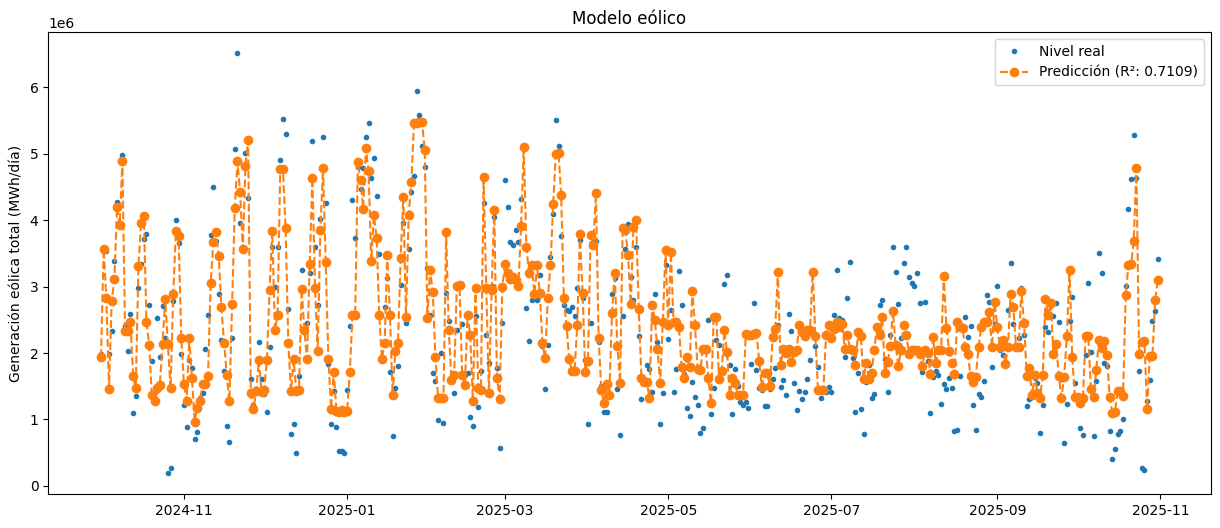

In [2]:
import pandas as pd
import numpy as np
import xgboost as xgb
from sklearn.metrics import r2_score, mean_absolute_error
from sklearn.model_selection import TimeSeriesSplit
import matplotlib.pyplot as plt
import os

DATA_PATH = '../data/2_processed/dataset_maestro_5min.parquet'
df_5min = pd.read_parquet(DATA_PATH)
df_5min = df_5min.sort_index()

agg_dict = {
    'eol': 'sum',
    'viento_nacional_ponderado': 'first',
    'dia_año_sin': 'first',
    'dia_año_cos': 'first',
}

df_1d = df_5min.resample('D').agg(agg_dict)
df_1d = df_1d.rename(columns={ 'eol': 'eol_total_dia' })

df_1d['eol_total_lag_7d'] = df_1d['eol_total_dia'].shift(7)
df_1d['eol_total_lag_14d'] = df_1d['eol_total_dia'].shift(14)
df_1d['eol_total_mean_28d'] = df_1d['eol_total_dia'].shift(7).rolling(window=28).mean() 


df_1d = df_1d.dropna() 

TARGET_NIVEL = 'eol_total_dia'
FEATURES_NIVEL = [
    'viento_nacional_ponderado',
    'dia_año_sin',
    'dia_año_cos',
    'eol_total_lag_7d',
    'eol_total_lag_14d',
    'eol_total_mean_28d'
]

X = df_1d[FEATURES_NIVEL]
y = df_1d[TARGET_NIVEL]

TEST_START_DATE_DIARIO = '2024-10-01'
X_train = X.loc[X.index < TEST_START_DATE_DIARIO]
y_train = y.loc[y.index < TEST_START_DATE_DIARIO]

X_test = X.loc[X.index >= TEST_START_DATE_DIARIO]
y_test = y.loc[y.index >= TEST_START_DATE_DIARIO]

model_nivel_eol = xgb.XGBRegressor(
    n_estimators=1000,
    learning_rate=0.01,
    max_depth=3,
    objective='reg:squarederror',
    early_stopping_rounds=50,
    n_jobs=-1,
    random_state=42
)

model_nivel_eol.fit(X_train, y_train,
                    eval_set=[(X_train, y_train), (X_test, y_test)],
                    verbose=100)

MODEL_PATH = '../models/modelo_eol.json'
model_nivel_eol.save_model(MODEL_PATH)

preds_nivel = model_nivel_eol.predict(X_test)
r2_nivel = r2_score(y_test, preds_nivel)
mae = mean_absolute_error(y_test, preds_nivel)

print(f"R^2: {r2_nivel:.4f}")
print(f"MAE: {mae:.2f} MWh/día")

plt.figure(figsize=(15, 6))
plt.plot(y_test.index, y_test, label='Nivel real', marker='.', linestyle='None')
plt.plot(y_test.index, preds_nivel, label=f'Predicción (R²: {r2_nivel:.4f})', 
         linestyle='--', marker='o')
plt.title('Modelo eólico')
plt.ylabel('Generación eólica total (MWh/día)')
plt.legend()
plt.show()